<a href="https://colab.research.google.com/github/ravillaleite/CVQKD-Reconciliation/blob/main/CVQKDreconciliation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_fec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

fatal: destination path 'OptiCommPy' already exists and is not an empty directory.
Processing /content/OptiCommPy
  Preparing metadata (setup.py) ... done
  Created wheel for OptiCommPy: filename=OptiCommPy-0.10.0-py3-none-any.whl size=102753 sha256=7bad045b495344ef92fdcc88b489f9057996b786a7771f719abe183280e822a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-1kb5ypec/wheels/0a/b3/b4/c1f785c2fbf2de32a986f34e6d5146d854df27f3012a7f465d
Successfully built OptiCommPy
  Attempting uninstall: OptiCommPy
    Found existing installation: OptiCommPy 0.10.0
    Uninstalling OptiCommPy-0.10.0:
      Successfully uninstalled OptiCommPy-0.10.0


#OptiComPy contributions

This section contains the main cells and functions obtained from the OptiComPy repository (https://github.com/edsonportosilva/OptiCommPy/tree/main), especially from the files:
https://github.com/edsonportosilva/OptiCommPy/blob/main/examples/test_fec.ipynb
and
https://github.com/edsonportosilva/OptiCommPy/blob/main/optic/comm/fec.py

authored by Professor Dr. Edson Porto Da Silva, UFCG.

In [2]:
from optic.comm.modulation import modulateGray, demodulateGray, grayMapping
from optic.comm.metrics import calcLLR, fastBERcalc, monteCarloGMI
from optic.comm.fec import encodeLDPC, decodeLDPC, plotBinaryMatrix, summarizeAlistFolder
from optic.dsp.core import pnorm
from optic.models.channels import awgn
from optic.plot import pconst
from optic.utils import parameters
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path
import time
from scipy.sparse import csr_matrix

In [ ]:
%load_ext autoreload
%autoreload 2

## Simulate forward error correction (FEC)

Basic simulation using LDPC encoding and decoding functions available in OptiCommPy.

In [ ]:
if 'google.colab' in str(get_ipython()):
    alistFolder = '/content/OptiCommPy/optic/comm/ALIST/'
else:
    # get the path of the current file and the repo path
    filePath = Path().resolve()
    repoPath = str(filePath.parent)
    alistFolder = repoPath + r'\optic\comm\ALIST\\' # change this to the path of the ALIST folder

print('Summary of ALIST files currently available in the repo:')
summarizeAlistFolder(alistFolder)

Summary of ALIST files currently available in the repo:
+-----------------------------------+------------+------------+-------+-------------+---------------+
|                File               | n (length) | m (checks) |  Rate | Max Var Deg | Max Check Deg |
+-----------------------------------+------------+------------+-------+-------------+---------------+
|     LDPC_DVBS2_64800b_R23.txt     |   64800    |   21600    | 0.667 |    64800    |       10      |
|  LDPC_IEEE_802.11nD2_648b_R23.txt |    648     |    216     | 0.667 |     648     |       11      |
|     LDPC_DVBS2_64800b_R14.txt     |   64800    |   48600    | 0.250 |    64800    |       4       |
|  LDPC_IEEE_802.11nD2_648b_R34.txt |    648     |    162     | 0.750 |     648     |       15      |
|     LDPC_DVBS2_64800b_R89.txt     |   64800    |    7200    | 0.889 |    64800    |       27      |
| LDPC_IEEE_802.11nD2_1944b_R34.txt |    1944    |    486     | 0.750 |     1944    |       15      |
|     LDPC_AR4JA_18720b_R7

## Test LDPC encoder/decoder

Below are just the functions that may need some modification.

In [ ]:
import logging as logg
import os

import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange
from numba.typed import List
from prettytable import PrettyTable
from scipy.sparse import coo_matrix, csc_matrix, csr_matrix

def readAlist(filename):
    """
    Read an ALIST file and reconstruct the binary parity-check matrix H.

    Parameters
    ----------
    filename : str
        Path to the ALIST file.

    Returns
    -------
    H : ndarray of shape (m, n)
        Reconstructed binary parity-check matrix.
    """
    with open(filename, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    n, m = map(int, lines[0].split())
    var_conn_lines = lines[4 : 4 + n]

    H = np.zeros((m, n), dtype=np.uint8)

    for j, line in enumerate(var_conn_lines):
        for entry in map(int, line.split()):
            if entry > 0:
                H[entry - 1, j] = 1

    return csr_matrix(H)

@njit


def writeAlist(H, filename):
    """
    Save a binary parity-check matrix H (numpy array) to ALIST format.

    Parameters
    ----------
    H : ndarray of shape (m, n)
        Binary parity-check matrix.
    filename : str
        Name of the ALIST file to be written.
    """
    # A função 'todense' gera a matriz 'completa' com os zeros
    if type(H) == csr_matrix:
        H = csr_matrix.todense(H).astype(np.uint8)
    elif type(H) == csc_matrix:
        H = csc_matrix.todense(H).astype(np.uint8)
    elif type(H) == coo_matrix:
        H = coo_matrix.todense(H).astype(np.uint8)
    else:
        H = H.astype(np.int8)

    m, n = H.shape

    # Variable and check node degrees
    varDegrees = [int(np.sum(H[:, j])) for j in range(n)]
    checkDegrees = [int(np.sum(H[i, :])) for i in range(m)]
    maxColDeg = max(varDegrees)
    maxRowDeg = max(checkDegrees)

    with open(filename, "w") as f:
        f.write(f"{n} {m}\n")
        f.write(f"{maxColDeg} {maxRowDeg}\n")

        f.write(" ".join(str(d) for d in varDegrees) + "\n")
        f.write(" ".join(str(d) for d in checkDegrees) + "\n")

        # Variable node connections (1-based indexing)
        for j in range(n):
            connections = np.where(H[:, j] == 1)[0] + 1
            padded = list(connections) + [0] * (maxColDeg - len(connections))
            f.write(" ".join(str(i) for i in padded) + "\n")

        # Check node connections (1-based indexing)
        for i in range(m):
            connections = np.where(H[i, :] == 1)[1] + 1
            padded = list(connections) + [0] * (maxRowDeg - len(connections))
            f.write(" ".join(str(j) for j in padded) + "\n")

    f.close()


#Here, the function works directly with csr.matrix, being incompatible with numba.
def encodeLDPC(bits, param):
    """
    Encode binary sequences using a parity-check matrix of a LDPC code.

    Parameters
    ----------
    bits : ndarray of shape (k, N)
        Binary input sequences to be encoded. Each column is a bit sequence of length :math:`k` bits.
    param : object
        Object containing the following attributes:

        - mode : str
            Mode of operation ('DVBS2', 'IEEE_802.11nD2', or 'AR4JA').

        - H : ndarray of shape (n - k, n)
            Binary parity-check matrix :math:`H`.

        - G : ndarray of shape (k, n), optional
            Binary generator matrix :math:`G`.

        - systematic : bool, optional
            If True, the generator matrix is assumed to be in systematic form. If False,
            the generator matrix is treated as a general linear transformation (default is True).

        - P1 : ndarray of shape (m, k), optional
            Matrix used for encoding in triangular mode.

        - P2 : ndarray of shape (m, k), optional
            Matrix used for encoding in triangular mode.

    Returns
    -------
    codewords : ndarray of shape (n, N)
        Binary encoded codewords. Each column is a codeword of length :math:`n` corresponding
        to the respective input bit sequence.

    References
    ----------
    [1] T. J. Richardson and R. L. Urbanke, "Efficient encoding of low-density parity-check codes," IEEE Transactions on Information Theory, vol. 47, no. 2, pp. 638-656, Feb 2001.

    """
    # check input parameters
    mode = getattr(param, "mode", "DVBS2")
    n = getattr(param, "n", 64800)
    R = getattr(param, "R", "1/4")
    H = getattr(param, "H", None)
    G = getattr(param, "G", None)
    systematic = getattr(param, "systematic", True)
    P1 = getattr(param, "P1", None)
    P2 = getattr(param, "P2", None)
    path = getattr(param, "path", None)

    if H is None:
        try:
            filename = f"LDPC_{mode}_{n}b_R{R[0]}{R[2]}.txt"
            H = readAlist(path + filename)
            param.H = H
        except FileNotFoundError:
            logg.error(
                f"File {filename} not found. Please provide a valid parity-check matrix H."
            )
    print('Tipo de H: ', type(H))

    return (H.dot(bits) % 2)




@njit(parallel=True)


def sumProductAlgorithm(llrs, checkNodes, varNodes, syndrome_y, maxIter, prec=np.float32):
    """
    Performs belief propagation decoding using the sum-product algorithm (SPA) for multiple codewords.

    Parameters
    ----------
    llrs : ndarray of shape (n, numCodewords)
        Array of log-likelihood ratios (LLRs) for each bit of the received codeword.
    checkNodes : list of ndarray
        List of length :math:`m`, where each element is a 1D array containing the indices
        of variable nodes (bits) involved in the corresponding check node (parity-check equation).
    varNodes : list of ndarray
        List of length :math:`n`, where each element is a 1D array containing the indices
        of check nodes that the corresponding variable node participates in.
    maxIter : int
        Maximum number of belief propagation iterations.
    prec : data-type, optional
        Data type for the computations (default is np.float32).

    Returns
    -------
    finalLLR : ndarray of shape (n,)
        Updated log-likelihood ratios after message passing.
    numIter : int
        Number of iterations executed until decoding converged or reached `maxIter`.
    frameDecodingFail : ndarray of shape (numCodewords,)
        Array indicating whether decoding was successful (0) or failed (1) for each codeword.
        A value of 0 indicates successful decoding, while 1 indicates failure.

    References
    ----------
    [1] F. R. Kschischang, B. J. Frey and H. . -A. Loeliger, "Factor graphs and the sum-product algorithm," IEEE Transactions on Information Theory, vol. 47, no. 2, pp. 498-519, Feb 2001.

    [2] T. J. Richardson and R. L. Urbanke, "The capacity of low-density parity-check codes under message-passing decoding," IEEE Transactions on Information Theory, vol. 47, no. 2, pp. 599-618, Feb 2001.
    """
    m, n = len(checkNodes), len(varNodes)
    msgVtoC = np.zeros((m, n), dtype=prec)
    msgCtoV = np.zeros((m, n), dtype=prec)
    llrs = llrs.astype(prec)
    print('Shape llrs: ', np.shape(llrs))

    #numCodewords = llrs.shape[1]
    numCodewords = 1
    finalLLR = np.zeros(n, dtype=prec)
    #frameDecodingFail = np.ones((numCodewords,), dtype=np.int8)
    #lastIter = np.zeros((numCodewords,), dtype=np.uint32)

    #for indCw in range(numCodewords):
    decodedBits = np.zeros(n, dtype=np.uint8)
    llr = llrs.copy()
        # Initialize variable-to-check messages with input LLRs
    for var in prange(n):
        for check in varNodes[var]:
            msgVtoC[check, var] = llr[var]

    for indIter in range(maxIter):
        # Check-to-variable update
        for check in prange(m):
            for var_idx in range(len(checkNodes[check])):
                var = checkNodes[check][var_idx]
                product = 1.0
                for neighbor_idx in range(len(checkNodes[check])):
                    neighbor = checkNodes[check][neighbor_idx]
                    if neighbor != var:
                        product *= np.tanh(msgVtoC[check, neighbor] / 2)
                product *= (1-2*syndrome_y[check]) #Liveris et. al term
                product = min(0.999999, max(-0.999999, product))  # clip
                msgCtoV[check, var] = 2 * np.arctanh(product)

        # Variable-to-check update
        for var in prange(n):
            for check_idx in range(len(varNodes[var])):
                check = varNodes[var][check_idx]
                sumMsg = llr[var]
                for neighbor_idx in range(len(varNodes[var])):
                    neighbor = varNodes[var][neighbor_idx]
                    if neighbor != check:
                        sumMsg += msgCtoV[neighbor, var]
                msgVtoC[check, var] = sumMsg

        # Final LLR computation
        for var in prange(n):
            finalLLR[var] = llr[var]
            for check in varNodes[var]:
                finalLLR[var] += msgCtoV[check, var]
                decodedBits[var] = (-np.sign(finalLLR[var]) + 1) // 2

        # Check parity conditions (cálculo da síndrome)
        parity_checks = np.zeros(m, dtype=np.uint8)
        for indParity in prange(m):
            for check in checkNodes[indParity]:
                    parity_checks[indParity] ^= decodedBits[check]  # accumulate XORs
        #print('Soma parity: ', np.sum(parity_checks))

        #Verificação com a síndrome de Bob
        success = False
        if np.all(parity_checks == syndrome_y):
          print('Síndromes igualadas!')
          #frameDecodingFail = 0
          lastIter = indIter
          success = True
          break

            #if np.sum(parity_checks) == 0:
            #    frameDecodingFail[indCw] = 0
            #    lastIter[indCw] = indIter
            #    break

        if indIter == maxIter - 1:
            lastIter = indIter

    return finalLLR, lastIter, decodedBits, success
    #return finalLLR


@njit(parallel=True, fastmath=True)



def minSumAlgorithm(llrs, checkNodes, varNodes, maxIter, prec=np.float32):
    """
    Performs belief propagation decoding using the Min-Sum Algorithm (MSA) for multiple codewords.

    Parameters
    ----------
    llrs : ndarray of shape (n, numCodewords)
        Log-likelihood ratios (LLRs) of the received codeword bits.
    checkNodes : list of ndarray
        List of length :math:`m`, where each entry contains the indices of variable nodes
        connected to the corresponding check node.
    varNodes : list of ndarray
        List of length :math:`n`, where each entry contains the indices of check nodes
        connected to the corresponding variable node.
    maxIter : int
        Maximum number of iterations for belief propagation.
    prec : data-type, optional
        Numerical precision to use in computations (default is np.float32).

    Returns
    -------
    finalLLR : ndarray of shape (n,)
        Updated LLR values for the decoded codeword after the final iteration.
    numIter : int
        Number of iterations performed before successful decoding or reaching `maxIter`.
    frameDecodingFail : ndarray of shape (numCodewords,)
        Array indicating whether decoding was successful (0) or failed (1) for each codeword.
        A value of 0 indicates successful decoding, while 1 indicates failure.

    References
    ----------
    [1] M. P. C. Fossorier, M. Mihaljevic and H. Imai, "Reduced complexity iterative decoding of low-density parity check codes based on belief propagation," IEEE Transactions on Communications, vol. 47, no. 5, pp. 673-680, May 1999
    """
    m, n = len(checkNodes), len(varNodes)
    msgVtoC = np.zeros((m, n), dtype=prec)
    msgCtoV = np.zeros((m, n), dtype=prec)
    llrs = llrs.astype(prec)

    #numCodewords = llrs.shape[1]
    numCodewords = 1
    finalLLR = np.zeros((n, numCodewords), dtype=prec)
    frameDecodingFail = np.ones((numCodewords,), dtype=np.int8)
    lastIter = np.zeros((numCodewords,), dtype=np.uint32)

    for indCw in range(numCodewords):
        decodedBits = np.zeros(n, dtype=np.uint8)
        llr = llrs[:, indCw]

        # Initialize variable-to-check messages with input LLRs
        for var in prange(n):
            for check in varNodes[var]:
                msgVtoC[check, var] = llr[var]

        for indIter in range(maxIter):
            # Check-to-variable update (Min-Sum)
            for check in prange(m):
                for var in checkNodes[check]:
                    signProduct = 1
                    min_abs = np.inf
                    for neighbor in checkNodes[check]:
                        if neighbor != var:
                            val = msgVtoC[check, neighbor]
                            signProduct *= np.sign(val)
                            min_abs = min(min_abs, abs(val))
                    msgCtoV[check, var] = signProduct * min_abs

            # Variable-to-check update
            for var in prange(n):
                for check in varNodes[var]:
                    sumMsg = llr[var]
                    for neighbor in varNodes[var]:
                        if neighbor != check:
                            sumMsg += msgCtoV[neighbor, var]
                    msgVtoC[check, var] = sumMsg

            # Final LLR and decision
            for var in prange(n):
                finalLLR[var, indCw] = llr[var]
                for check in varNodes[var]:
                    finalLLR[var, indCw] += msgCtoV[check, var]
                decodedBits[var] = (-np.sign(finalLLR[var, indCw]) + 1) // 2

            # Check parity conditions
            parity_checks = np.zeros(m, dtype=np.uint8)
            for indParity in prange(m):
                for check in checkNodes[indParity]:
                    parity_checks[indParity] ^= decodedBits[check]  # accumulate XORs

            if np.sum(parity_checks) == 0:
                frameDecodingFail[indCw] = 0
                lastIter[indCw] = indIter
                break

            if indIter == maxIter - 1:
                lastIter[indCw] = indIter

    return finalLLR, lastIter, frameDecodingFail



def decodeLDPC(llrs, param, syndrome_y):
    """
    Decode multiple LDPC codewords using the belief propagation algorithms.

    Parameters
    ----------
    llrs : ndarray of shape (n, numCodewords)
        Array of log-likelihood ratios (LLRs) for each bit of the received codewords.
        Codewords are assumed to be disposed in columns.
    param : object
        Object containing the following attributes:

        - H : ndarray of shape (m, n)
            Sparse binary parity-check matrix of the LDPC code.

        - maxIter : int
            Maximum number of iterations for belief propagation.

        - alg : str
            Decoding algorithm to use ('SPA' for sum-product or 'MSA' for min-sum).

        - prec : data-type
            Numerical precision to use in computations (default is np.float32).

    Returns
    -------
    decodedBits : ndarray of shape (n, numCodewords)
        Array of decoded bits for each codeword.
    outputLLRs : ndarray of shape (n, numCodewords)
        Array of updated log-likelihood ratios (LLRs) after decoding.
    """
    # check input parameters
    H = getattr(param, "H", None)
    maxIter = getattr(param, "maxIter", 25)
    alg = getattr(param, "alg", "SPA")
    prec = getattr(param, "prec", np.float32)

    if H is None:
        logg.error("H is None. Please provide a valid parity-check matrix.")

    m, n = H.shape
    #numCodewords = llrs.shape[1]
    numCodewords = 1
    #n_ = llrs.shape[0]
    n_ = len(llrs)
    Hcsc = H.tocsc()  # convert to CSC format for efficient column access

    llrs = np.clip(llrs, -200, 200)
    outputLLRs = np.zeros_like(llrs, dtype=prec)

    # depuncturing LLRs if necessary
    if n_ < n:
        llrs = np.pad(llrs, ((0, n - n_), (0, 0)), mode="constant")

    # Build adjacency lists using fixed-size lists for Numba
    checkNodes = List([H[i].indices.astype(np.uint32) for i in range(m)])
    varNodes = List([Hcsc[:, j].indices.astype(np.uint32) for j in range(n)])

    logg.info(f"Decoding {numCodewords} LDPC codewords with {alg}")
    if alg == "SPA":
        outputLLRs, lastIter, decodedBitsSPA, success = sumProductAlgorithm(
        #outputLLRs = sumProductAlgorithm(
          llrs, checkNodes, varNodes, syndrome_y, maxIter, prec
        )
    elif alg == "MSA":
        outputLLRs, lastIter, frameErrors = minSumAlgorithm(
            llrs, checkNodes, varNodes, maxIter, prec
        )
    else:
        logg.error(f"Unsupported algorithm: {alg}. Supported algorithms are: SPA, MSA.")
        return None, None


    return decodedBitsSPA, outputLLRs, lastIter, success


# Authoral Contributions

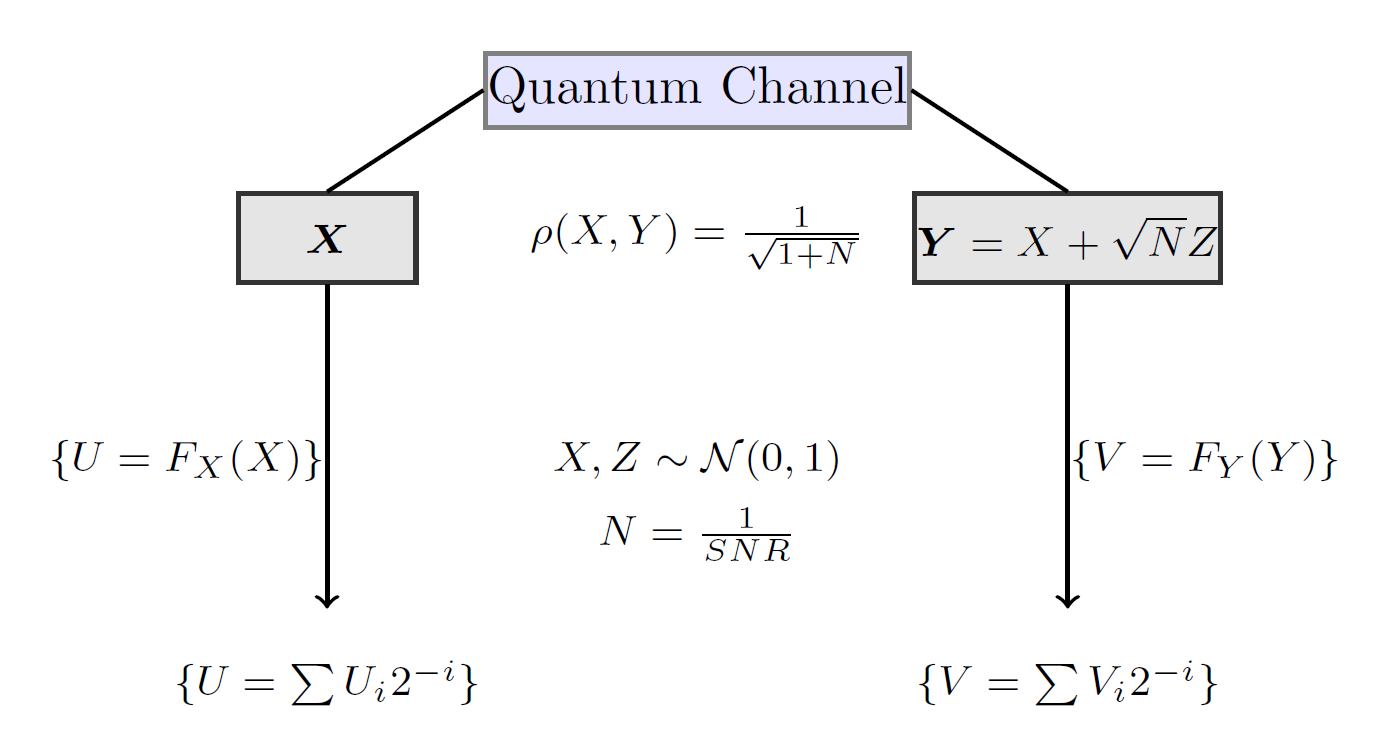

In [ ]:
#Distributional Transform Expansion Functions

def ecdf(sample):

    # convert sample to a numpy array, if it isn't already
    sample = np.atleast_1d(sample)

    # find the unique values and their corresponding counts
    quantiles, counts = np.unique(sample, return_counts=True)

    # take the cumulative sum of the counts and divide by the sample size to
    # get the cumulative probabilities between 0 and 1
    cumprob = np.cumsum(counts).astype(np.double) / sample.size

    return quantiles, cumprob

def d2b(n):

    strtemp = ''
    while n != 0:
        resto = str(int(n%2))
        strtemp = resto + '' + strtemp
        n = np.floor(n/2)

    return strtemp

#teste = d2b(8)
#print (teste, type(teste))
# ----------------------------------------------------------------------------
#Convert real numbers not integers to binary sequences.

#n = 10.7560

def f_d2b(n, bits_de_representacao):

    #bits_de_representacao = 3
    strn = str(n)
    #strn = strn.strip()
    strn = strn.replace(' ', '')

    if strn.find('.') == (-1):
        return d2b(n)
    else:
        k = strn.find('.')

    i_part = strn[0:k]
    f_part = strn[k::]

    number_i_part = int(i_part)
    number_f_part = float(f_part)

    bin_i_part = d2b(number_i_part)


    strtemp = ''
    temp = number_f_part
    #t = '1'
    #s = '0'

    aux = 0
    inf = 0
    sup = 1
    media = (sup - inf) / 2

    while aux < bits_de_representacao:

        if temp >= media:

            strtemp = strtemp + '1'
            inf = media
            media = ((sup - inf) / 2) + inf

        else:

            strtemp = strtemp + '0'
            sup = media
            media = ((sup - inf) / 2) + inf

        aux += 1

    if(i_part == '0'):
        return strtemp
    else:
        return (bin_i_part + '.' + strtemp)

In this application, we do not refer to information exchange. Instead, the goal is to reconstruct Bob's sequence on Alice's side using her own sequence X and a compressed version of Bob's sequence, provided by the syndrome of Y, in a reverse reconciliation scheme.
- First, Bob's syndrome is sent to Alice through an error-free, authenticated classical channel.
- Sequences X and Y are random binary sequences obtained via Distributional Transform Expansion (DTE), which induces virtual Binary Symmetric Channel (BSC) subchannels for each realization of A and B — Gaussian random sequences generated by Alice and Bob — with a length of N.
- Next, Log-Likelihood Ratios (LLRs) are computed from the error probabilities of each BSC subchannel obtained via DTE.
The decoder operates using X (LLRs derived from X) and S(Y).
- For this simulation, we exclusively used the Sum-Product algorithm.

In [ ]:
import numpy as np

SNRdB_list = np.linspace(2, 7, 6)
SNR_list = 10**(SNRdB_list/10)

mu0 = 0
sigma = 1
#sigmar = 1/SNR_list

realizacoes = 64800
bits_de_representacao = 2
max_iterations = 50

Entropia = np.zeros(len(SNR_list))
Pe = np.zeros(len(SNR_list))
Pe_media = np.zeros(len(SNR_list))
cont_sucessos = np.zeros(len(SNR_list)) #number of times the syndromes are matched
success_full = np.zeros(len(SNR_list)) #number of times the sequences are matched
dist_after_decoding = np.zeros(len(SNR_list))
mean_of_iterations = np.zeros(len(SNR_list))

for iterations in range(0, max_iterations):

    M = np.random.normal(mu0, sigma, (100000, 1))
    #Gaussian values of Alice
    x = M

    #cont_SNR = 0
    Pe_SNR = np.zeros((len(SNRdB_list),bits_de_representacao))

    kx = np.zeros(realizacoes, dtype = int)
    probabilidade_acumulada_x = np.zeros(realizacoes)

    Matriz_Alice = np.zeros((realizacoes, bits_de_representacao), dtype=int)
    # compute the ECDF of the samples
    x1, px = ecdf(x)

    #Geração da matriz binária de Alice
    for i in range(0, realizacoes):

        indices = np.where(x1 == x[i])[0]  # Get the indexes where x1 == x[i]

        if indices.size > 0:  # Garante que há pelo menos um índice correspondente
            kx[i] = int(indices[0])  # Obtém o primeiro índice encontrado
            probabilidade_acumulada_x[i] = px[kx[i]]  # Atribui a probabilidade acumulada

        #foi gerado por Alice
        if probabilidade_acumulada_x[i] == 1:
            probabilidade_acumulada_x[i] = 0.99999
        elif probabilidade_acumulada_x[i] == 0:
            probabilidade_acumulada_x[i] = 0.00001

        expansao_base2_Alice_str = f_d2b(probabilidade_acumulada_x[i], bits_de_representacao)

        ii = 0
        for a in expansao_base2_Alice_str:
            #print('a: ', a)
            #Alice.append(a)
            Matriz_Alice[i,ii] = a
            ii += 1

    #print(np.shape(Matriz_Alice))

    # Gerando x e s(x) ---------------------------------------------------------------------------------------
    x = np.copy(Matriz_Alice[:,0])

    # --------------------------------------------------------------------------------------------------------
    #Para cada valor de SNR, será gerada uma sequência para Y, que será comparada com o X gerado inicialmente

    d_hamming = np.zeros((len(SNR_list), realizacoes))
    dist = np.zeros(len(SNR_list))

    for glob in range(0,len(SNR_list)):
        sigmar = sigma / np.sqrt(SNR_list[glob])

        Mr = np.random.normal(mu0, sigmar, (100000, 1)) #ruído

        #Valores de Bob
        y = M + Mr
        y1, py = ecdf(y)

        ky = np.zeros(realizacoes, dtype = int)
        probabilidade_acumulada_y = np.zeros(realizacoes)
        Matriz_Bob = np.zeros((realizacoes, bits_de_representacao), dtype = int)
        #Geração da matriz binária de Bob
        for ii in range(0, realizacoes):

            indices_y = np.where(y1 == y[ii])[0]
            if indices_y.size > 0:  # Garante que há pelo menos um índice correspondente
                ky[ii] = int(indices_y[0])  # Obtém o primeiro índice encontrado
                probabilidade_acumulada_y[ii] = py[ky[ii]]  # Atribui a probabilidade acumulada

            #foi recebido por Bob
            if probabilidade_acumulada_y[ii] == 1:
                probabilidade_acumulada_y[ii] = 0.99999
            elif probabilidade_acumulada_y[ii] == 0:
                probabilidade_acumulada_y[ii] = 0.00001

            expansao_base2_Bob_str = f_d2b(probabilidade_acumulada_y[ii], bits_de_representacao)
            #Bob = []
            iii = 0
            for b in expansao_base2_Bob_str:
                #print("b", b)
                Matriz_Bob[ii,iii] = b
                iii = iii + 1

        # Gerando y e s(y) --------------------------------------------------------------------
        y = np.copy(Matriz_Bob[:,0])

        d_hamming[glob,:] = np.mod(x + y, 2) #difference vector between x and y
        #print('Soma da distancia: ', np.sum(d_hamming[glob,:]))
        #print('Shape dhamming: ', np.shape(d_hamming))
        dist[glob] = np.sum(d_hamming[glob,:])
        #print('Shape dist: ', np.shape(dist))
        Pe[glob] = dist[glob] / realizacoes
        Entropia[glob] = -Pe[glob]*np.log2(Pe[glob]) - (1-Pe[glob])*np.log2(1-Pe[glob])
        Pe_media[glob] = Pe_media[glob] + Pe[glob]

        # Calculate the syndrome of y and applying to the decoder
        paramEnc = parameters()
        paramEnc.mode = 'DVBS2' #'IEEE_802.11nD2', 'DVBS2'
        paramEnc.n = 64800
        paramEnc.R = '1/4'
        paramEnc.path = alistFolder

        k = (paramEnc.n*int(paramEnc.R[0]))//int(paramEnc.R[2])
        start = time.time()
        syndromeBitsY = encodeLDPC(y, paramEnc)
        end = time.time()
        print(f'Time for encoding - total: {(end-start):.2f} ms')

        Nwords = 1    # number of codewords
        nIter  = 50

        variable_nodes = x.copy()

        m, n = np.shape(paramEnc.H)
        llrs = np.zeros(n)

        for i in range(0,n):
            llrs[i]=(1-2*variable_nodes[i]) * np.log((1-Pe[glob])/(Pe[glob]))

        # soft-decoding
        paramDec = parameters()
        paramDec.H = paramEnc.H
        paramDec.alg = 'SPA'
        paramDec.maxIter = nIter
        paramDec.prgsBar = True
        paramDec.prec = np.float32

        start = time.time()
        decodedBits, llr_dec, numberIter, success = decodeLDPC(llrs, paramDec, syndromeBitsY)
        #llrs_nova = decodeLDPC(llrs, paramDec, syndromeBitsY)
        end = time.time()
        print(f'Time for decoding - total: {end-start:.2f} s')
        print(f'Number of iterations: {numberIter}')

        frameError = 1

        #if numberIter < 49:
        if success:
          cont_sucessos[glob] += 1 #Success count by SNR

        if np.all(decodedBits == y):
            frameError -= 1
            success_full[glob] += 1

        mean_of_iterations[glob] += numberIter

        #print(f'Frame error, it global {iterations}: {frameError}')
    print(iterations)



Pe_media = Pe_media/max_iterations
print(f'Pe media: ', Pe_media)

mean_of_iterations = mean_of_iterations / max_iterations
cont_sucessos = cont_sucessos / max_iterations
success_full = success_full / max_iterations

np.savetxt('Mean_of_iterations.txt', mean_of_iterations, fmt='%f')
np.savetxt('Cont_sucess.txt', cont_sucessos, fmt='%f')
np.savetxt('Sequencias_igualadas.txt', success_full, fmt='%f')

Tipo de H:  <class 'scipy.sparse._csr.csr_matrix'>
Time for encoding - total: 11.60 ms
Shape llrs:  (64800,)
Time for decoding - total: 16.50 s
Number of iterations: 49
Tipo de H:  <class 'scipy.sparse._csr.csr_matrix'>
Time for encoding - total: 11.60 ms
Shape llrs:  (64800,)
Time for decoding - total: 15.91 s
Number of iterations: 49
Tipo de H:  <class 'scipy.sparse._csr.csr_matrix'>
Time for encoding - total: 11.60 ms
Shape llrs:  (64800,)
Síndromes igualadas!
Time for decoding - total: 16.12 s
Number of iterations: 48
Tipo de H:  <class 'scipy.sparse._csr.csr_matrix'>
Time for encoding - total: 11.63 ms
Shape llrs:  (64800,)
Síndromes igualadas!
Time for decoding - total: 12.94 s
Number of iterations: 31
Tipo de H:  <class 'scipy.sparse._csr.csr_matrix'>
Time for encoding - total: 11.67 ms
Shape llrs:  (64800,)
Síndromes igualadas!
Time for decoding - total: 10.79 s
Number of iterations: 22
Tipo de H:  <class 'scipy.sparse._csr.csr_matrix'>
Time for encoding - total: 11.62 ms
Shape

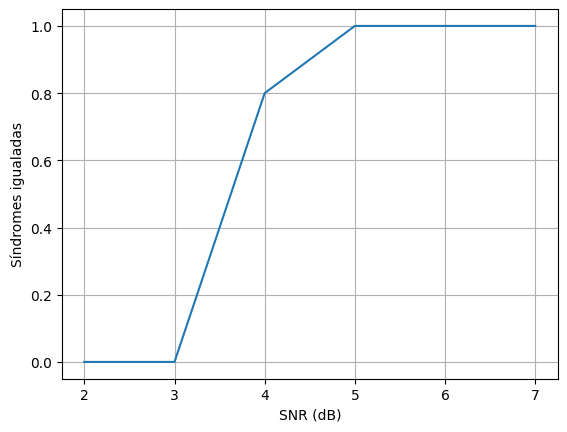

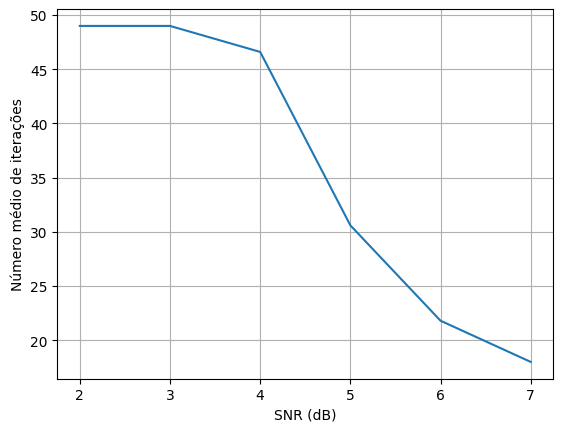

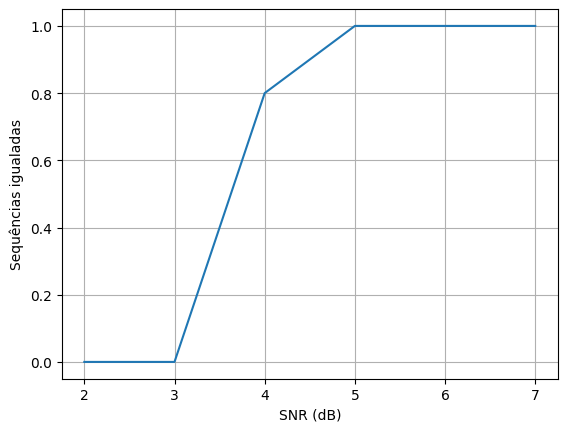

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(SNRdB_list, cont_sucessos)
ax1.set_xlabel('SNR (dB)')
ax1.set_ylabel('Síndromes igualadas')
ax1.grid(True)

fig, ax2 = plt.subplots()
ax2.plot(SNRdB_list, mean_of_iterations)
ax2.set_xlabel('SNR (dB)')
ax2.set_ylabel('Número médio de iterações')
ax2.grid(True)

fig, ax3 = plt.subplots()
ax3.plot(SNRdB_list, success_full)
ax3.set_xlabel('SNR (dB)')
ax3.set_ylabel('Sequências igualadas')
ax3.grid(True)